# Decision Tree

In [35]:
# Decision tree
#Insert the parameter ranges we want to evaluate.
#For the decision tree, we can look at the performance of the classifier with 
#different depth values.
hyper_parameters_decision_tree = [{'max_depth':[max(1,n_depth * 2) for n_depth in range(21)]}]

In [36]:
#Start cross validation and draw the ROC curves
mean_tpr_tree = 0.0
mean_fpr_tree = np.linspace(0, 1, 100)

('Decision tree ', 0, 'best parameters', 'true values 0.221')
{'max_depth': 4}
-2151.935 (+/-103.853) for {'max_depth': 1}
-2151.675 (+/-104.565) for {'max_depth': 2}
-2104.537 (+/-98.080) for {'max_depth': 4}
-2126.934 (+/-115.898) for {'max_depth': 6}
-2151.935 (+/-170.819) for {'max_depth': 8}
-2267.045 (+/-184.785) for {'max_depth': 10}
-2352.466 (+/-209.343) for {'max_depth': 12}
-2423.303 (+/-150.304) for {'max_depth': 14}
-2469.399 (+/-95.687) for {'max_depth': 16}
-2533.205 (+/-136.938) for {'max_depth': 18}
-2533.205 (+/-129.511) for {'max_depth': 20}
-2552.737 (+/-108.818) for {'max_depth': 22}
-2567.061 (+/-87.259) for {'max_depth': 24}
-2591.281 (+/-157.266) for {'max_depth': 26}
-2604.302 (+/-176.523) for {'max_depth': 28}
-2597.531 (+/-169.903) for {'max_depth': 30}
-2597.271 (+/-199.950) for {'max_depth': 32}
-2604.042 (+/-207.241) for {'max_depth': 34}
-2630.866 (+/-169.869) for {'max_depth': 36}
-2635.294 (+/-92.811) for {'max_depth': 38}
-2622.793 (+/-182.117) for {'m

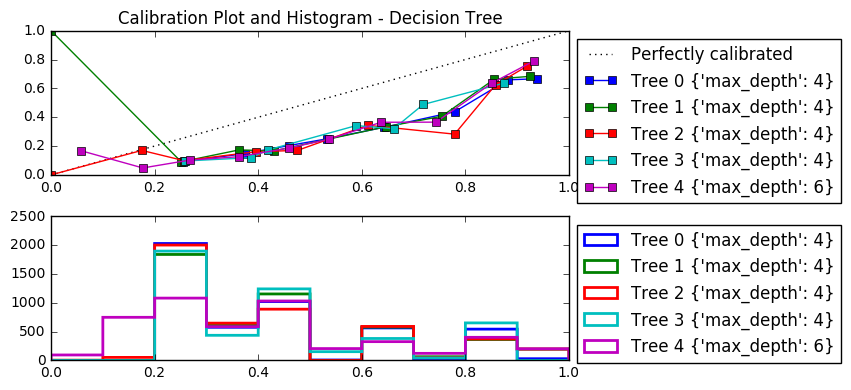

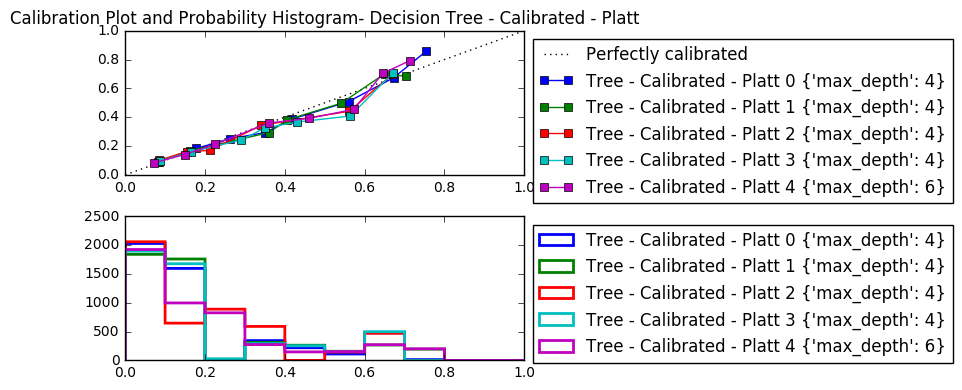

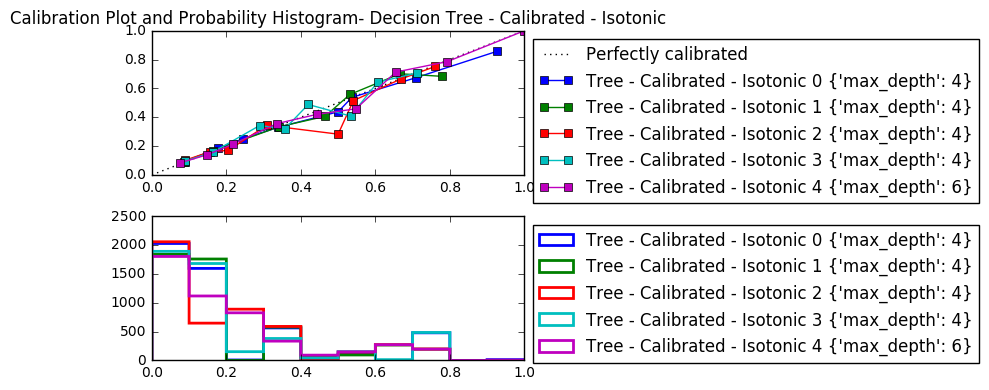

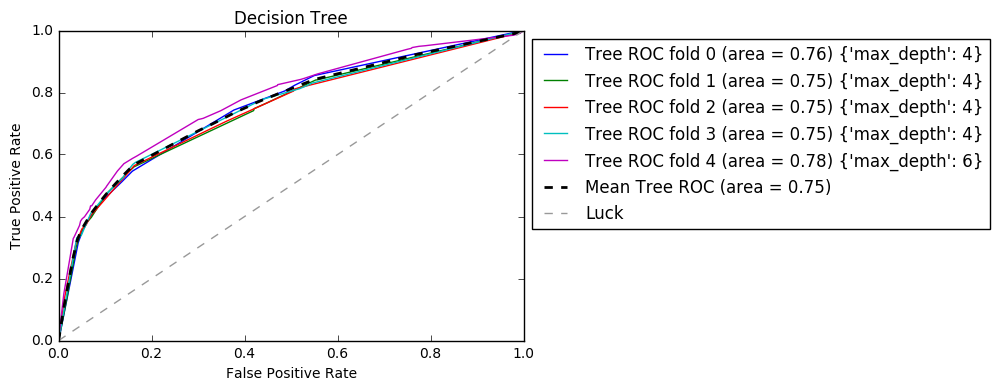

In [37]:
#The first plot will display the Calibration Plot and Histogram
plt.figure(1)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Platt's method
plt.figure(2)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])

#The first plot will display the Calibration Plot and Histogram for 
#probabilities calibrated with Isotonic regression
plt.figure(3)
plt.subplot(211)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])


for i, (train, validation) in enumerate(cv):
    #Start with decision tree
    #We are going to use grid search to find the optimal values
    #scikit-learn uses an optimised version of the CART algorithm.
    #It is more important to capture the customers who default, 
    #therefore 'recall' is the score with which we evaluate the model 
    #performance. We also balance the data by sampling the 'paid' and 'default'
    #classes inversely proportional to their frequency 
    classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', min_samples_split = 2, max_features = X.shape[1],
                                              min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_leaf_nodes = None, class_weight = 'balanced',
                                              random_state= 1, presort=False)
    #Create an instance of the grid search class
    grid_decision_tree = GridSearchCV(classifier_decision_tree,hyper_parameters_decision_tree,cv = 5, scoring = score_cost,refit = True)
    
    #Fit decision tree
    grid_decision_tree.fit(X_train_validation[train],y_train_validation[train])
    print('Decision tree ',i,'best parameters','true values %0.03f' % (sum(y_train_validation[train])/len(y_train_validation[train])))
    print(grid_decision_tree.best_params_)
    for params, mean_score, scores in grid_decision_tree.grid_scores_:
        print('%0.3f (+/-%0.03f) for %r' % (mean_score, scores.std() * 2, params))
    
    #Calibrate probabilities with Platt's method. This is equivalent to fitting a logistic regression to 
    #true class values in the traning set using the uncalibrated predicted probabilities
    probas_tree_train = grid_decision_tree.predict_proba(X_train_validation[train])[:,1]    
    lr.fit(probas_tree_train.reshape( -1, 1 ),y_train_validation[train])    

    #Calibrate probabilities with isotonic regression. Isotonic regression fits a 
    #non-decreasing function to the data
    ir.fit(probas_tree_train,y_train_validation[train])
    
    #Predict the test set in the current fold
    #Use decision tree. Index 1 includes the probabilities of belonging to class '1' (delayed)
    probas_tree_validation = grid_decision_tree.predict_proba(X_train_validation[validation])[:,1]
    #Calculate the calibrated probabilities with Platt's method    
    probas_tree_calibrated_platt = lr.predict_proba(probas_tree_validation.reshape( -1, 1 ))[:,1]
    #Calculate the calibrated probabilities with isotonic regression
    probas_tree_calibrated_isotonic = ir.transform(probas_tree_validation)     
    
    #Plot the calibration curves
    fraction_of_positives_tree, mean_predicted_value_tree = calibration_curve(y_train_validation[validation], probas_tree_validation, n_bins=10)
    #Plot the calibration curves for calibrated probabilities platt
    fraction_of_positives_tree_calibrated_platt, mean_predicted_value_tree_calibrated_platt = calibration_curve(y_train_validation[validation], probas_tree_calibrated_platt, n_bins=10)
    #Plot the calibration curves for calibrated probabilities isotonic
    fraction_of_positives_tree_calibrated_isotonic, mean_predicted_value_tree_calibrated_isotonic = calibration_curve(y_train_validation[validation], probas_tree_calibrated_isotonic, n_bins=10)
            
    # Compute ROC curve and the area under the curve
    fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train_validation[validation], probas_tree_validation)
    mean_tpr_tree += interp(mean_fpr_tree, fpr_tree, tpr_tree)
    mean_tpr_tree[0] = 0.0
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    plt.figure(4)    
    plt.plot(fpr_tree, tpr_tree, lw=1, label='Tree ROC fold %d (area = %0.2f) %r' % (i, roc_auc_tree,grid_decision_tree.best_params_))

    plt.figure(1)
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree,fraction_of_positives_tree,"s-",label = 'Tree %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_validation,range=(0,1),bins= 10, label = "Tree %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)

    plt.figure(2)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree_calibrated_platt,fraction_of_positives_tree_calibrated_platt,"s-",label = 'Tree - Calibrated - Platt %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_calibrated_platt,range=(0,1),bins= 10, label = "Tree - Calibrated - Platt %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)
    
    plt.figure(3)    
    plt.subplot(211)
    plt.plot(mean_predicted_value_tree_calibrated_isotonic,fraction_of_positives_tree_calibrated_isotonic,"s-",label = 'Tree - Calibrated - Isotonic %d %r' % (i,grid_decision_tree.best_params_))
    plt.subplot(212)
    plt.hist(probas_tree_calibrated_isotonic,range=(0,1),bins= 10, label = "Tree - Calibrated - Isotonic %d %r" % (i,grid_decision_tree.best_params_),histtype = "step", lw = 2)
       
#Draw the mean ROC curve
plt.figure(4)    
mean_tpr_tree /= len(cv)
mean_tpr_tree[-1] = 1.0
mean_auc_tree = auc(mean_fpr_tree, mean_tpr_tree)
plt.plot(mean_fpr_tree, mean_tpr_tree, 'k--',label='Mean Tree ROC (area = %0.2f)' % mean_auc_tree, lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.title('Decision Tree')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.savefig('Mean Tree ROC')

plt.figure(1)
plt.subplot(211)
plt.title('Calibration Plot and Histogram - Decision Tree')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree')

plt.figure(2)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram- Decision Tree - Calibrated - Platt')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree - Calibrated - Platt')

plt.figure(3)
plt.subplot(211)
plt.title('Calibration Plot and Probability Histogram- Decision Tree - Calibrated - Isotonic')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.subplot(212)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.savefig('Calibration Plot and Histogram - Decision Tree - Calibrated - Isotonic')


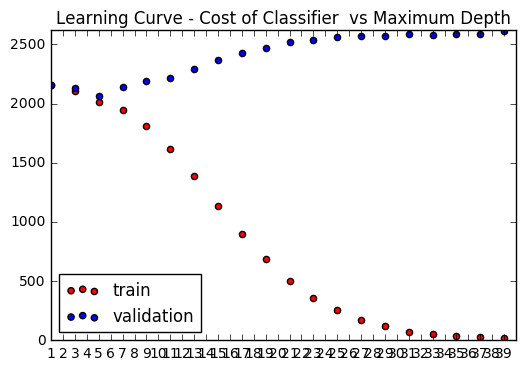

In [38]:
#Plot the learning curve to assess the fit as the max depth of the tree increases
train_cost = []
validation_cost = []

train_cost_cv = np.zeros((n_folds))
validation_cost_cv = np.zeros((n_folds))

steps = xrange(1,41,2)


for i in steps:
    classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best',max_features= X.shape[1], min_samples_split = 2, 
                                          min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_depth = i, max_leaf_nodes = None, class_weight = 'balanced',
                                          random_state= 1, presort=False)
    for j, (train, validation) in enumerate(cv):
        classifier_decision_tree.fit(X_train_validation[train], y_train_validation[train])
        train_predictions = classifier_decision_tree.predict(X_train_validation[train])
        test_predictions = classifier_decision_tree.predict(X_train_validation[validation])                                  
        train_cost_cv[j] = expected_cost(y_train_validation[train], train_predictions)         
        validation_cost_cv[j] = expected_cost(y_train_validation[validation], test_predictions)
    train_cost.append(np.mean(train_cost_cv))
    validation_cost.append(np.mean(validation_cost_cv))
        
plt.figure(5)    
plt.scatter(steps, train_cost, c = 'red',label = 'train')
plt.scatter(steps, validation_cost, c = 'blue',label = 'validation')
plt.xticks(np.arange(1, max(steps) + 1, 1))
plt.xlim([1,max(steps) + 1])
plt.ylim([0,max(max(train_cost),max(validation_cost)) + 1])
plt.title('Learning Curve - Cost of Classifier  vs Maximum Depth')
plt.legend(loc="lower left")
plt.savefig('Learning Curve')

The validation model cost decreases until the tree depth reaches 5, then starts to go up as the model overfits. The train model cost eventually reaches zero as the training dataset is predicted perfectly. The graph suggests that the ideal depth of the tree should be around 5.

In [39]:
#We are going to use 4 as the max tree depth. This gave the best result in the 
#grid search, and the learning curve shows that beyond this depth the tree starts to 
#overfit, as indicated by the increasing validation cost
classifier_decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy',splitter = 'best',max_features= X_train_validation.shape[1], min_samples_split = 2, 
                                          min_samples_leaf = 1, min_weight_fraction_leaf=0.0, max_depth = 4, max_leaf_nodes = None, class_weight = 'balanced',
                                          random_state= 1, presort=False)

In [40]:
#Use the train and validation data to fit the model with the optimal depth parameter
classifier_decision_tree.fit(X_train_validation,y_train_validation) 

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=4, max_features=30L, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [41]:
#Get training probabilities for probability calibration
decision_tree_probabilities_train = classifier_decision_tree.predict_proba(X_train_validation)[:,1]

In [42]:
#calibrate probabilities with isotonic regression
ir.fit(decision_tree_probabilities_train,y_train_validation)      

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None)

In [43]:
#calibrate probabilities with platt's method
lr.fit(decision_tree_probabilities_train.reshape( -1, 1 ),y_train_validation)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

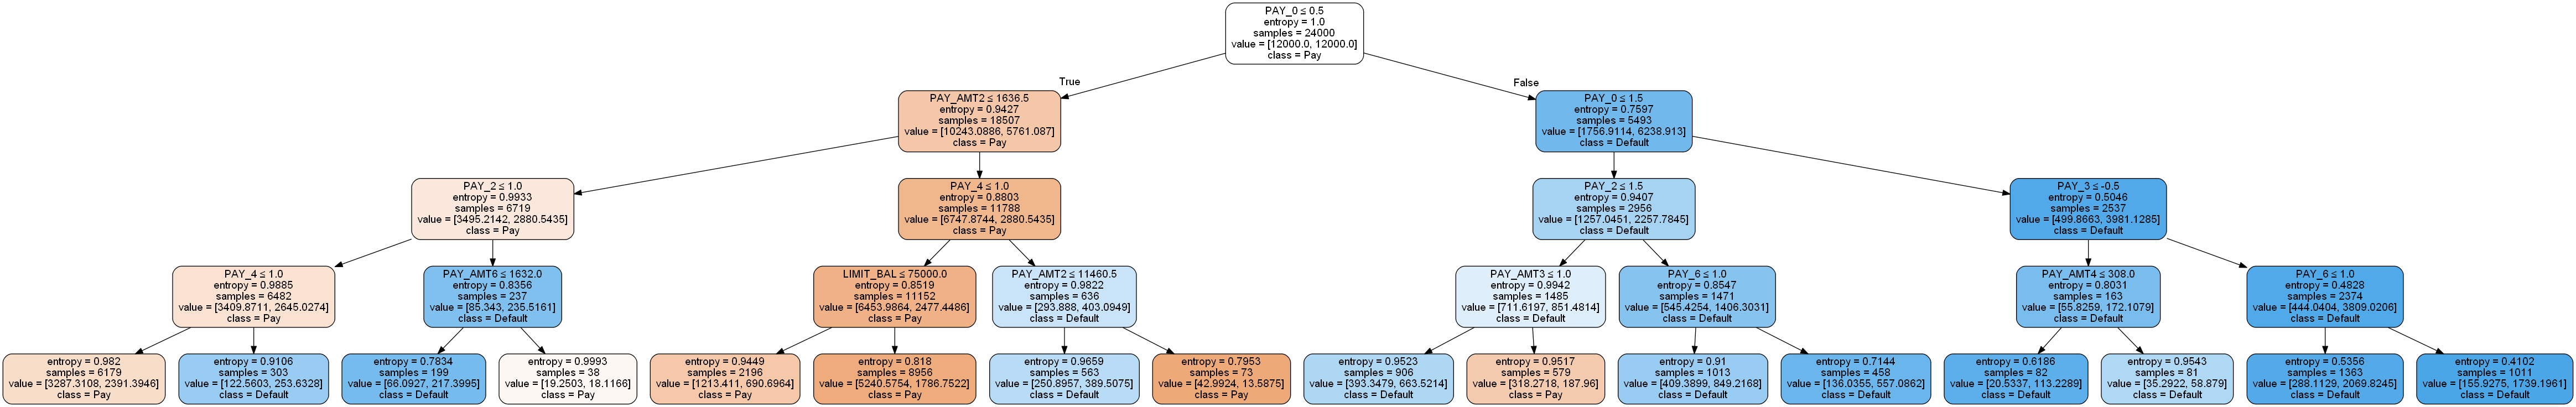

In [44]:
#Draw the decision tree
classlist = ['Pay','Default']
dot_data = StringIO()  
tree.export_graphviz(classifier_decision_tree, out_file=dot_data,  
                         feature_names=variable_names,  
                         class_names=classlist,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("tree_classifier.png") 
Image(filename='tree_classifier.png') 

Entropy reported in the graph is a measure of impurity of a node. It is calculated as:

$$\sum{-p_{i}log(p_{i})}$$

Where $p_{i}$ is the probability of the observations in the node to belong to class $i$ and it is calculated as the number of observations that belong to class $i$, divided by the total number of observations in the node.

In [45]:
#Get the feature importances and names in dataframe
importance = pd.DataFrame(classifier_decision_tree.feature_importances_,columns = ['Importance'],index = variable_names)
importance = importance.sort_values(by = 'Importance', axis = 0, ascending = False)
pd.DataFrame(importance).to_csv('importance_tree.csv',index = False)
print(importance[:10])

           Importance
PAY_0        0.783766
PAY_AMT2     0.070019
PAY_4        0.058292
PAY_2        0.038415
PAY_AMT3     0.015415
LIMIT_BAL    0.014302
PAY_6        0.009554
PAY_3        0.005754
PAY_AMT4     0.002450
PAY_AMT6     0.002034


The last payment status (PAY_0) is the variable which contributes most to the minimization of the entropy score.

In [46]:
#Use the decision tree model on the test set and get uncalibrated probabilities
decision_tree_probabilities_test = classifier_decision_tree.predict_proba(X_test)[:,1]
#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_cost = [0 if x < threshold_cost else 1 for x in decision_tree_probabilities_test]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_50 = [0 if x < threshold_05 else 1 for x in decision_tree_probabilities_test]
#Calibrate the probabilities by isotonic regression 
probas_tree_calibrated_isotonic = ir.transform(decision_tree_probabilities_test)
#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_calibrated_isotonic_cost = [0 if x < threshold_cost else 1 for x in probas_tree_calibrated_isotonic]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_calibrated_isotonic_50 = [0 if x < threshold_05 else 1 for x in probas_tree_calibrated_isotonic]
#Calibrate the probabilities by isotonic regression 
probas_tree_calibrated_platt = lr.predict_proba(decision_tree_probabilities_test.reshape( -1, 1 ))[:,1]
#Use the cost sensitive threshold to predict the outcome
decision_tree_predictions_test_calibrated_platts_cost = [0 if x < threshold_cost else 1 for x in probas_tree_calibrated_platt]
#Use the 50% threshold to predict the outcome
decision_tree_predictions_test_calibrated_platts_50 = [0 if x < threshold_05 else 1 for x in probas_tree_calibrated_platt]

In [47]:
#Print the expected cost and the classification report for uncalibrated probabilities, 
#isotonic calibrated probabilities and platts calibrated probabilities
#with cost-sensitive threshold and 50% threshold
print('Uncalibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_cost))
print(classification_report(y_test, decision_tree_predictions_test_cost,target_names = ['Pay','Default']))
print('Uncalibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_50))
print(classification_report(y_test, decision_tree_predictions_test_50,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_isotonic_cost))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_isotonic_cost,target_names = ['Pay','Default']))
print('Isotonic calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_isotonic_50))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_isotonic_50,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, cost sensitive threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_platts_cost))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_platts_cost,target_names = ['Pay','Default']))
print('Platts calibrated probabilities, 50pct threshold: %i ' % expected_cost(y_test, decision_tree_predictions_test_calibrated_platts_50))
print(classification_report(y_test, decision_tree_predictions_test_calibrated_platts_50,target_names = ['Pay','Default']))
print('Dummy classifier: %i ' % expected_cost(y_test, clf_predictions))
print(classification_report(y_test, clf_predictions,target_names = ['Pay','Default']))

Uncalibrated probabilities, cost sensitive threshold: 3879 
             precision    recall  f1-score   support

        Pay       0.85      0.00      0.01      4663
    Default       0.22      1.00      0.36      1337

avg / total       0.71      0.23      0.09      6000

Uncalibrated probabilities, 50pct threshold: 2132 
             precision    recall  f1-score   support

        Pay       0.87      0.85      0.86      4663
    Default       0.50      0.54      0.52      1337

avg / total       0.78      0.78      0.78      6000

Isotonic calibrated probabilities, cost sensitive threshold: 2132 
             precision    recall  f1-score   support

        Pay       0.87      0.85      0.86      4663
    Default       0.50      0.54      0.52      1337

avg / total       0.78      0.78      0.78      6000

Isotonic calibrated probabilities, 50pct threshold: 2339 
             precision    recall  f1-score   support

        Pay       0.84      0.95      0.89      4663
    Default 

C:\Users\Mustafa\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


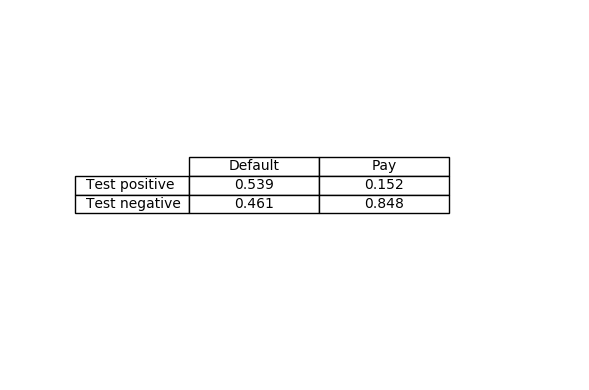

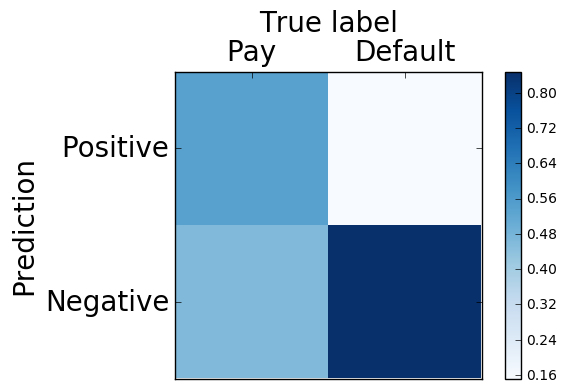

In [48]:
#Plot the confusion matrix 
cm = confusion_matrix_custom(y_test,decision_tree_predictions_test_calibrated_isotonic_cost)
cm = np.round(cm, decimals = 3)
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=cm,
          rowLabels=['Test positive','Test negative'],
          colLabels=['Default','Pay'],
          cellLoc='center',colWidths=[0.25, 0.25],
          loc='center')
plt.tight_layout()

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation='none')
fig.colorbar(im)
locs = np.arange(len(np.unique(y_test)))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks(locs + 0.5)
ax.xaxis.set(ticks=locs, ticklabels=['Pay','Default'])
ax.yaxis.set_ticks(locs + 0.5)
ax.yaxis.set(ticks=locs, ticklabels=['Positive','Negative'])
plt.xlabel('True label', fontsize=20)
plt.ylabel('Prediction', fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
ax.grid(False) 